# Prediction Agent — Single Run Visualization

Load the latest run from `outputs/run_log.jsonl` and visualize:
- Tool outputs
- Weights
- Final score
- Score vs threshold

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

# Load the most recent run from the detailed paper_bets log
PAPER_BETS_LOG = Path("outputs/paper_bets.jsonl")
RUN_LOG = Path("outputs/run_log.jsonl")

def load_latest_run(log_path: Path) -> dict:
    """Load the last line from a JSONL file."""
    lines = log_path.read_text().strip().split("\n")
    return json.loads(lines[-1])

def load_all_runs(log_path: Path) -> list:
    """Load all lines from a JSONL file."""
    lines = log_path.read_text().strip().split("\n")
    return [json.loads(line) for line in lines]

# Load data
if PAPER_BETS_LOG.exists():
    latest = load_latest_run(PAPER_BETS_LOG)
    print(f"Loaded run: {latest['run_id']}")
    print(f"Market: {latest['event_input']['market_title']}")
    print(f"Price: {latest['event_input']['current_price']}")
else:
    print("No paper_bets.jsonl found. Run the pipeline first:")
    print("  python -m prediction_agent.main --skip-watcher")

Loaded run: 53f9fb3e
Market: Lakers vs Celtics: Lakers Win
Price: 0.55


Tool Outputs:
--------------------------------------------------
  mock_price_signal         → [0.55]
  mock_random_context       → [0.763426]


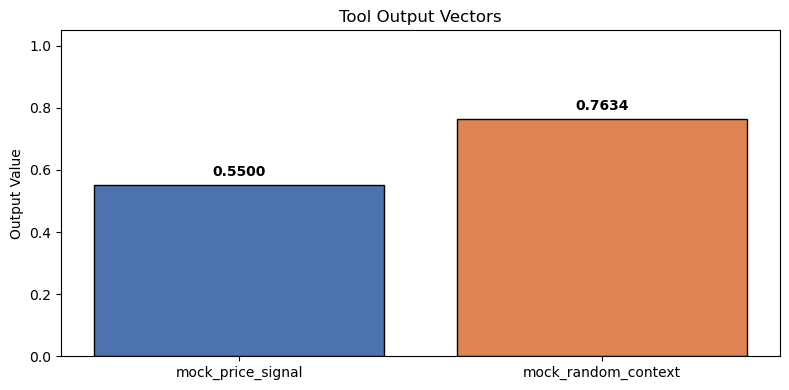

In [2]:
# ── Tool Outputs ──────────────────────────────
if PAPER_BETS_LOG.exists():
    tool_outputs = latest["score_result"]["tool_outputs"]
    
    print("Tool Outputs:")
    print("-" * 50)
    for to in tool_outputs:
        print(f"  {to['tool_name']:25s} → {to['output_vector']}")
    
    # Bar chart of tool output values
    names = [to["tool_name"] for to in tool_outputs]
    values = [to["output_vector"][0] for to in tool_outputs]
    
    fig, ax = plt.subplots(figsize=(8, 4))
    bars = ax.bar(names, values, color=["#4C72B0", "#DD8452"][:len(names)], edgecolor="black")
    ax.set_ylabel("Output Value")
    ax.set_title("Tool Output Vectors")
    ax.set_ylim(0, 1.05)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f"{val:.4f}", ha="center", va="bottom", fontweight="bold")
    plt.tight_layout()
    plt.show()

Agent Selections:
--------------------------------------------------
  mock_price_signal         weight=0.50
  mock_random_context       weight=0.50
  Threshold                 = 0.6000
  Rationale: Deterministic fallback: equal-weight both mock tools, threshold 0.6.


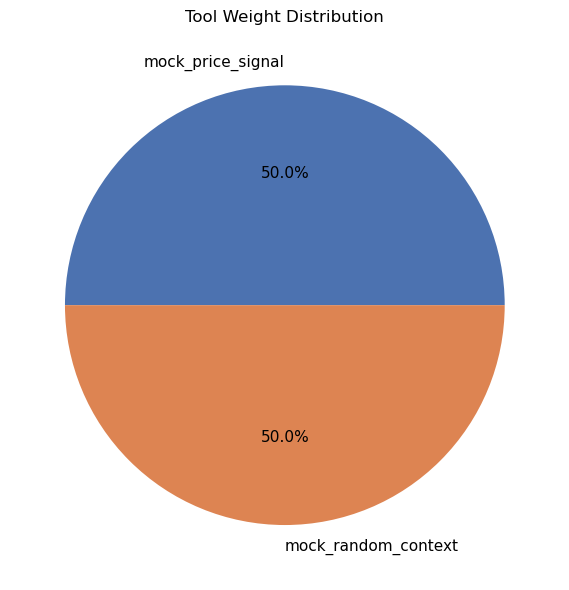

In [3]:
# ── Weights ────────────────────────────────────
if PAPER_BETS_LOG.exists():
    selections = latest["formula_spec"]["selections"]
    
    print("Agent Selections:")
    print("-" * 50)
    for sel in selections:
        print(f"  {sel['tool_name']:25s} weight={sel['weight']:.2f}")
    print(f"  {'Threshold':25s} = {latest['formula_spec']['threshold']:.4f}")
    print(f"  Rationale: {latest['formula_spec']['rationale']}")
    
    # Pie chart of weights
    w_names = [s["tool_name"] for s in selections]
    w_vals = [s["weight"] for s in selections]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    wedges, texts, autotexts = ax.pie(
        w_vals, labels=w_names, autopct="%1.1f%%",
        colors=["#4C72B0", "#DD8452"][:len(w_names)],
        textprops={"fontsize": 11},
    )
    ax.set_title("Tool Weight Distribution")
    plt.tight_layout()
    plt.show()

Final Score:   0.6567
Threshold:     0.6000
Bet Triggered: True


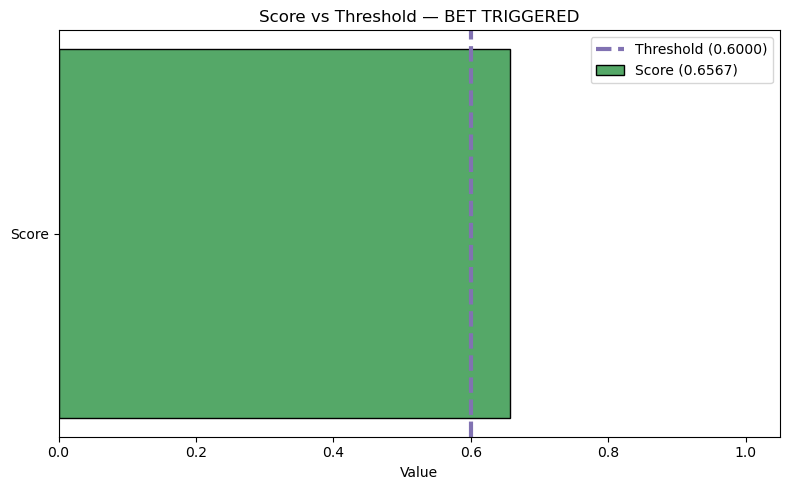

In [4]:
# ── Final Score vs Threshold ───────────────────
if PAPER_BETS_LOG.exists():
    score = latest["score_result"]["final_score"]
    threshold = latest["score_result"]["threshold"]
    triggered = latest["score_result"]["bet_triggered"]
    
    print(f"Final Score:   {score:.4f}")
    print(f"Threshold:     {threshold:.4f}")
    print(f"Bet Triggered: {triggered}")
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Score bar
    color = "#55A868" if triggered else "#C44E52"
    ax.barh(["Score"], [score], color=color, height=0.4, edgecolor="black", label=f"Score ({score:.4f})")
    
    # Threshold line
    ax.axvline(x=threshold, color="#8172B2", linewidth=3, linestyle="--", label=f"Threshold ({threshold:.4f})")
    
    ax.set_xlim(0, 1.05)
    ax.set_xlabel("Value")
    ax.set_title(f"Score vs Threshold — {'BET TRIGGERED' if triggered else 'NO BET'}")
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

Weighted Contributions:
               tool   signal  weight  contribution
  mock_price_signal 0.550000     0.5      0.275000
mock_random_context 0.763426     0.5      0.381713

Sum = 0.6567


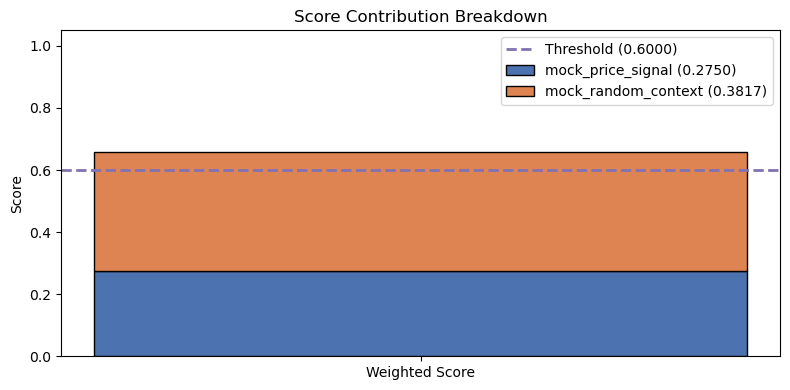

In [5]:
# ── Weighted Contribution Breakdown ────────────
if PAPER_BETS_LOG.exists():
    contributions = []
    for to, sel in zip(tool_outputs, selections):
        signal = to["output_vector"][0]
        weight = sel["weight"]
        contrib = signal * weight
        contributions.append({
            "tool": sel["tool_name"],
            "signal": signal,
            "weight": weight,
            "contribution": contrib,
        })
    
    df = pd.DataFrame(contributions)
    print("Weighted Contributions:")
    print(df.to_string(index=False))
    print(f"\nSum = {df['contribution'].sum():.4f}")
    
    # Stacked bar
    fig, ax = plt.subplots(figsize=(8, 4))
    bottom = 0
    colors = ["#4C72B0", "#DD8452", "#55A868", "#C44E52"]
    for i, row in df.iterrows():
        ax.bar("Weighted Score", row["contribution"], bottom=bottom,
               label=f"{row['tool']} ({row['contribution']:.4f})",
               color=colors[i % len(colors)], edgecolor="black")
        bottom += row["contribution"]
    
    ax.axhline(y=threshold, color="#8172B2", linewidth=2, linestyle="--", label=f"Threshold ({threshold:.4f})")
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score")
    ax.set_title("Score Contribution Breakdown")
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [6]:
# ── Watcher Ticks (if present) ─────────────────
if PAPER_BETS_LOG.exists():
    ticks = latest.get("watcher_ticks", [])
    if ticks:
        tick_df = pd.DataFrame(ticks)
        print(f"Watcher: {len(ticks)} ticks")
        print(tick_df[["polled_price", "threshold", "triggered"]].to_string(index=False))
        
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(range(len(ticks)), tick_df["polled_price"], "o-", color="#4C72B0", label="Polled Price")
        ax.axhline(y=tick_df["threshold"].iloc[0], color="#C44E52", linestyle="--", label="Threshold")
        ax.set_xlabel("Tick")
        ax.set_ylabel("Price")
        ax.set_title("Watcher Price Polling")
        ax.set_ylim(0, 1.05)
        ax.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No watcher ticks (watcher was skipped or no data).")

No watcher ticks (watcher was skipped or no data).


In [7]:
# ── Run Summary ────────────────────────────────
if PAPER_BETS_LOG.exists():
    print("=" * 60)
    print("RUN SUMMARY")
    print("=" * 60)
    print(f"  Run ID:       {latest['run_id']}")
    print(f"  Market:       {latest['event_input']['market_title']}")
    print(f"  Market Price: {latest['event_input']['current_price']:.4f}")
    print(f"  Final Score:  {latest['score_result']['final_score']:.4f}")
    print(f"  Threshold:    {latest['score_result']['threshold']:.4f}")
    print(f"  Bet Placed:   {latest['bet_placed']}")
    print(f"  Bet Side:     {latest.get('bet_side', 'N/A')}")
    print(f"  Bet Amount:   ${latest.get('bet_amount', 0):.2f}")
    print("=" * 60)

RUN SUMMARY
  Run ID:       53f9fb3e
  Market:       Lakers vs Celtics: Lakers Win
  Market Price: 0.5500
  Final Score:  0.6567
  Threshold:    0.6000
  Bet Placed:   True
  Bet Side:     YES
  Bet Amount:   $10.00
